In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as st
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
from preprocessing import *
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

In [39]:
def N(t_scalar, t):
    """
    Returns the number of times in t less than or equal to t_scalar.
    Is used to compute N(t_{i,k}) and N'(t_{i,k}) depending on whether t above is t or t_prime
    """
    return np.searchsorted(t, t_scalar, side="right")

def getTimeDifferences(t, t_prime):
    """
    Input: (sorted) times for a particular station i
    Output: List of differences indexed by [h][k] for this station i
    """

    # h goes until N(t[-1], t) assuming T = t[-1]
    T = end_T
    D_result = []
    for h in range(1, N(T, t)+1):
        differences_list = []
        # Construct list of t_ih - t'_ik for k = 1 to N'(T)
        differences_list.append(t[h-1] - t_prime[N(t[h-2], t_prime):N(t[h-1], t_prime)])

        D_result.append(np.array(differences_list))

    return D_result

getTimeDifferences(np.array([1,2,3]),np.array([1.1,2.2,3.3]))

[array([], shape=(1, 0), dtype=float64), array([[0.9]]), array([[0.8]])]

In [40]:
def compensator_m4(t_scalar, t, t_prime, alpha_i, beta_i, alpha_i_prime, beta_i_prime,lambda_i):
    """
    t_scalar: scalar value where Lambda_i(t) is to be evaluated
    t_prime: list of arrival times at station i

    NOTE: t_prime NEEDS TO BE SORTED HERE.
    """

    term1 = lambda_i * t_scalar
    term2 = -(alpha_i_prime / beta_i_prime) * np.sum(np.exp(-beta_i_prime * (t_scalar - t_prime[:N(t_scalar, t_prime)]))-1)
    term3 = -(alpha_i / beta_i) * np.sum(np.exp(-beta_i * (t_scalar - t[:N(t_scalar, t)]))-1)
    return term1 + term2 + term3


In [51]:
def new_B(h, t, t_prime, beta, time_differences):

    """
    Returns a list of [B_i(1), ..., B_i(h)]

    NOTE: t_prime NEEDS to be sorted here

    time_differences: time differences double list for station i

    Note all index variables such as h, k, etc start at 1, like the mathematical notation.
    """
    B = [np.sum(np.exp(-beta*(t[0] - t_prime[:N(t[0], t_prime)])))]

    # Append the rest
    for l in range(2, h+1):
        # First term in recursive formula for B_i(h)
        term1 = np.exp(-beta*(t[l-1] - t[l-2])) * B[l-2]
        term2 = np.sum(np.exp(-beta*(time_differences[l-1])))
        B.append(term1 + term2)
    return np.array(B)


def new_A(h, t, beta):

    A = [0]
    for i in range(2, h+1):
            A.append(np.exp(-1*beta*(t[i-1] - t[i-2]))*(1+A[i-2]))
    return np.array(A)


def m4_log_likelihood(t, t_prime, time_differences, alpha_i, beta_i, alpha_i_prime, beta_i_prime, lambda_i):
    """
    Gives log likelihood of our five parameters. 
    t: start times from station i
    t_prime: end times at station i

    NOTE: t_prime NEEDS TO BE SORTED HERE
    """
    
    T = end_T # TODO: Is this how we get big T?

    # Get A list
    A_ = new_A(len(t), t, beta_i)

    # Get B list 
    B_ = new_B(len(t), t, t_prime, beta_i_prime, time_differences)

    term1 = np.sum(np.log(lambda_i + alpha_i_prime*B_[:len(t)+1] + alpha_i*A_[:len(t)+1]))

    term2 = -compensator_m4(T, t, t_prime, alpha_i, beta_i, alpha_i_prime, beta_i_prime, lambda_i)

    return term1 + term2


In [53]:
# Test m4 likelihood function
beta = 0.01

t = t_per_station[1]
t_prime = t_prime_per_station[1]

time_differences = getTimeDifferences(t, t_prime)

m4_log_likelihood(t, t_prime,time_differences, 0.1, 0.1, 0.01, 0.1, 0.01)

-8972.94409858594

## Finding the parameters using likelihood optimisation

In [54]:
time_diffs = {}
for st_id in tqdm(train_sorted_start_ids):
    t = t_per_station[st_id]
    t_prime = t_prime_per_station[st_id] # Need to sort t_prime for likelihood function
    time_diffs[st_id] = getTimeDifferences(t, t_prime)

100%|██████████| 789/789 [00:13<00:00, 57.22it/s]


In [55]:
model_2_params = pd.read_csv("../data/N_M_params.csv", index_col=0)
model_3_params = pd.read_csv("../data/M3_train_params.csv", index_col=0)
model_3_params

,alpha,beta,lambda
1,0.020179,0.035553,7.705058e-03
2,0.015271,0.016036,1.213006e-03
3,0.004644,0.004644,3.779973e-17
4,0.009820,0.023543,9.676464e-03
5,0.011876,0.012869,1.258996e-03
...,...,...,...
836,0.014502,0.039605,1.707352e-02
838,0.006228,0.006470,4.663218e-04
839,0.023140,0.028994,8.233945e-03
840,0.018468,0.019006,2.030979e-04


In [56]:
train_sorted_start_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  60,  61,  62,  63,  64,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 18

In [57]:
optimal_parameters = {}
for st_id in tqdm(train_sorted_start_ids[:4]):
    m2_station_params = model_2_params.loc[st_id].to_numpy()
    m3_station_params = model_3_params.loc[st_id].to_numpy()
    #x0 = [np.log(m2_station_params[0]), np.log(m2_station_params[1] -m2_station_params[0] ), np.log(m3_station_params[0]), np.log(m3_station_params[1] - m3_station_params[0]), np.log(m3_station_params[-1])] # np.log(rates_dict[station.start_id.unique()[0]])]
    x0 = -np.ones(5) * 3

    # TODO: What bounds should we use here?
    t = t_per_station[st_id]
    t_prime = t_prime_per_station[st_id] # Need to sort t_prime for likelihood function
    time_differences = time_diffs[st_id]
    op_m4_log_likelihood = lambda x: -m4_log_likelihood(t, t_prime, time_differences, np.exp(x[0]), np.exp(x[0]) + np.exp(x[1]) , np.exp(x[2]), np.exp(x[2] + x[3]), np.exp(x[4]))
    sol = op.minimize(op_m4_log_likelihood, x0, method="Nelder-Mead")
    # m4_log_likelihood(t, t_prime, time_differences, alpha_i, beta_i, alpha_i_prime, beta_i_prime, lambda_i):
    #sol = op.minimize(op_m3_likelihood, x0, method="SLSQP")
    if sol.success:
        transformed_alpha = np.exp(sol.x[0])
        transformed_beta = np.exp(sol.x[0]) + np.exp(sol.x[1])
        transformed_alpha_prime = np.exp(sol.x[2])
        transformed_beta_prime = np.exp(sol.x[2]) + np.exp(sol.x[3])
        transformed_lambda = np.exp(sol.x[4])
        max_params = [transformed_alpha, transformed_beta, transformed_alpha_prime, transformed_beta_prime, transformed_lambda]
        optimal_parameters[st_id] = max_params

    else:
        raise OptimizationError(f"Failed to converge for station {st_id}.")
optimal_parameters

100%|██████████| 4/4 [00:25<00:00,  6.45s/it]


{1: [0.013183804346844762,
  0.03204896550159225,
  0.01777630282414354,
  2.8405615087466374,
  0.004301538642541513],
 2: [0.1848084460174985,
  1.0013729920147205,
  0.012741137220732855,
  1.2997328904535017,
  0.0009639938161912862],
 3: [0.039253357457139,
  0.09996044961524642,
  0.003159864249373914,
  1.6548102340695694,
  4.495496431908357e-05],
 4: [0.2221891135967183,
  0.9659284236137465,
  0.007488718267348448,
  3.104779408468895,
  0.007395204151242728]}

## Assessing fit for model 4

In [58]:
optimal_parameters_df = pd.DataFrame(optimal_parameters.values(), index=optimal_parameters.keys(), columns = ["alpha", "beta","alpha_prime","beta_prime", "lambda"])
optimal_parameters_df

,alpha,beta,alpha_prime,beta_prime,lambda
1,0.013184,0.032049,0.017776,2.840562,0.004302
2,0.184808,1.001373,0.012741,1.299733,0.000964
3,0.039253,0.099960,0.003160,1.654810,0.000045
4,0.222189,0.965928,0.007489,3.104779,0.007395


In [62]:
compensated_times_dict = {}
for st_id in tqdm(train_sorted_start_ids[:4]):
    params = optimal_parameters_df.loc[st_id].to_numpy()
    tprime = test_t_prime_per_station[st_id]
    time = test_t_per_station[st_id]
    comp_st = lambda x: compensator_m4(x, time, tprime, params[0], params[1], params[2], params[3], params[4])
    compensated_times_dict[st_id] = [comp_st(i) for i in time]
#compensator_m4(t_scalar, t, t_prime, alpha_i, beta_i, alpha_i_prime, beta_i_prime,lambda_i)

100%|██████████| 4/4 [00:00<00:00, 83.60it/s]


In [63]:
m4_p_values = {}

for st_id in tqdm(test_sorted_start_ids[:4]):
    rate = rates_dict[st_id]
    inter_arrival_times = np.diff(compensated_times_dict[st_id])
    inter_arrival_times = np.insert(inter_arrival_times,0,compensated_times_dict[st_id][0])
    station_p_values = np.exp(-inter_arrival_times)
    m4_p_values[st_id] = station_p_values

100%|██████████| 4/4 [00:00<00:00, 6839.47it/s]


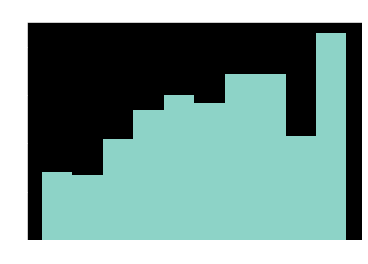

In [64]:
plt.title("Histogram of p-values for station 1 using Model 3")
plt.hist(m4_p_values[1])
plt.show()

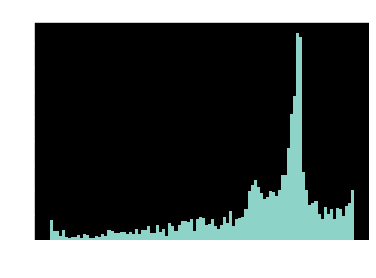

In [66]:
joined_p_values = np.concatenate(np.array(list(m4_p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations for Model 2")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values_m3.png")
plt.show()